**Voltage Step Evoked Potassium Currents in Starburst Amacrine Cells**

**Experimental Conditions:**

- Starburst Amacrine Cells in Chat-Cre/tdTomato mice were targeted for whole cell recording.
- For grna experiments and expeiments with bath application of drugs internal solution consisted of, 110 mM KMeS04H, 10 mM NaCl, 5 mM HEPES, 2 mM EGTA, 10 mM CrPhos, 4 mM Mg-ATP, and 0.4 mM Na-GTP was used.
- Cells were held in voltage clamp at -80mV and sustained and transient currents were recorded as voltage steps of (-110, -100, -90, -80, -70, -60, -50, -40, -30, -20) were applied.
- For experiments involving pharmacology, control currents were first recorded then drug was applied for approximately 20 minuets and the evoked currents were again recorded.
- As an added control, at the end of each experiment cells were held in current clamp and a series of depolarizing steps were applied to ensure cell did not fire action potentials.

In [ ]:
import pandas as pd
import numpy as np
import h5py
import os
import scipy
from scipy.optimize import curve_fit
import seaborn as sns
import matplotlib.pyplot as plt
from google.colab import drive
from google.colab import files


In [ ]:
# to access data from google drive
drive.mount('/content/drive')

Mounted at /content/drive


**Class PotassiumCurrentStepsImport**

The class PotassiumCurrentStepsImport is designed to import multiple HDF5 files belonging to a common experimental condition and return a single NumPy array. The returned data will be zero-baseline normalized and, optionally, the capacitive current can be subtracted out. The traces from each experiment can be plotted as well. To use the class, define the directory path, a list of the names of the hdf5 files, and a list of the desired traces within the file. After importing the data individual experiments can be identified based on the name of the file and trace number, for example trace 1 from file iPhys_2024_10_22 will be identified as iPhys_2024_10_22_trace_1. Note, control and experimental conditions should be imported separately, for example, two arrays should be produced for before and after drug application.

In [ ]:
class PotassiumCurrentStepsImport:
    """
    A class to import, normalize, and analyze electrophysiology evoked potassium current data from HDF5 files.

    Extracts current traces from specified experiments, normalizes the baseline,
    optionally applies capacitive current subtraction, and optionally plots each experiment.

    """
    def __init__(self, directory, experiments, traces, baseline_range=(5000, 5100), apply_capacitive_subtraction=True):
        """
        Initializes the PotassiumCurrentStepsImport class.

        Args:
            directory (str): The path to the directory containing HDF5 files.
            experiments (list of str): Names of HDF5 experiment files (excluding `.h5`).
            traces (list of int): Trace numbers within the HDF5 files to be analyzed.
            baseline_range (tuple of int, optional): The range `(start, end)` of samples to calculate baseline.
                                                     Default is (5000, 5100).
            apply_capacitive_subtraction (bool, optional): Whether to subtract capacitive current artifacts.
                                                           Default is True.

        Other Attributes:
            experiments_list (list of str): Stores names of processed experiments.
            normalized_data_list (list of np.ndarray): Stores normalized current traces.

        Returns:
            None
        """
        self.directory = directory
        self.experiments = experiments
        self.traces = traces
        self.baseline_range = baseline_range
        self.apply_capacitive_subtraction = apply_capacitive_subtraction
        self.experiments_list = []
        self.normalized_data_list = []

    def import_steps(self, file_path, trace_num):
        """
        Imports electrophysiology voltage step data from an HDF5 file.

        Args:
            file_path (str): Path to the HDF5 file.
            trace_num (int): The trace number to extract from the file.

        Returns:
            tuple:
                - experiment_name (str): Name of the processed experiment.
                - fully_normalized (np.ndarray): The normalized current data with shape (time points, voltage steps).
                                                 If an error occurs, returns (None, None).
        """
        file_name = os.path.splitext(os.path.basename(file_path))[0]
        experiment_name = f"{file_name}_trace_{trace_num}"

        try:
            with h5py.File(file_path, 'r') as hdf:
                trace_group = hdf[f'data/trace_{trace_num}']
                ephys_data_list = []

                for sweep_key in trace_group.keys():
                    sweep_group = trace_group[sweep_key]
                    ephys_group = sweep_group['ephys']
                    ephys_data = ephys_group['ChRead_0'][:]
                    ephys_data_list.append(ephys_data)

                ephys_array = np.vstack(ephys_data_list).T  # Stack into NumPy array

                # Apply baseline normalization
                experiment_name, baseline_normalized = self.normalize_baseline(experiment_name, ephys_array)

                # Apply capacitive subtraction if flag is True
                if self.apply_capacitive_subtraction:
                    fully_normalized = self.subtract_capacitive_current(experiment_name, baseline_normalized)
                else:
                    fully_normalized = baseline_normalized  # Capacitive current is NOT subtracted out

                self.experiments_list.append(experiment_name)
                self.normalized_data_list.append(fully_normalized)

                return experiment_name, fully_normalized

        except Exception as e:
            print(f"Error processing {file_path}: {e}")
            return None, None


    def normalize_baseline(self, experiment_name, ephys_array):
        """
        Zero normalizes the baseline based on the baseline range.

        Args:
            experiment_name (str): Name of the experiment.
            ephys_array (numpy array): Electrophysiology data.

        Returns:
            tuple:
                - experiment_name (str): Name of the experiment.
                - normalized_array (np.ndarray): Baseline-normalized data of the same shape.
        """
        if ephys_array is None:
            return None

        # Zero baseline normalization
        baseline_values = ephys_array[self.baseline_range[0]:self.baseline_range[1], :].mean(axis=0, keepdims=True)
        normalized_array = ephys_array - baseline_values
        return experiment_name, normalized_array

    def subtract_capacitive_current(self, experiment_name, normalized_array):
        """
        Subtracts out the capacitive current.

        Args:
            experiment_name (str): Name of the experiment.
            ephys_array (numpy array): Baseline-normalized electrophysiology data.

        Returns:
            np.ndarray: Data with capacitive artifacts removed.
        """

        # Remove capacitive current artifacts
        start_artifact = np.array([10001, 10002, 10003, 10004, 10005])
        end_artifact = np.array([20001, 20002, 20003, 20004, 20005])

        for sweep in range(normalized_array.shape[1]):
            normalized_array[start_artifact, sweep] += normalized_array[end_artifact, sweep]
            normalized_array[end_artifact, sweep] = 0  # Set to zero instead of subtracting itself

        return normalized_array

    def import_traces(self):
        """
        Iterates over experiments and traces, imports and normalizes data, and stores experiment names.

        Returns:
             np.ndarray: Array of normalized current data for all experiments. Each entry is a 2D array
                        (time points, voltage steps) stored as an object array.
        """

        for exp, trace in zip(self.experiments, self.traces):
            file_path = os.path.join(self.directory, exp + ".h5")
            experiment_name, fully_normalized = self.import_steps(file_path, trace)

        return np.array(self.normalized_data_list, dtype=object)

    def plot_traces(self, experiment_name):
        """
        Plots Traces.

        Args:
            experiment_name (str): Name of the experiment to plot.

        Returns:
            None
        """
        if experiment_name not in self.experiments_list:
            print(f"Experiment '{experiment_name}' not found.")
            return

        idx = self.experiments_list.index(experiment_name)
        data = self.normalized_data_list[idx]

        plt.figure(figsize=(6, 3))
        for i in range(data.shape[1]):
            plt.plot(data[:, i], label=f'Sweep {i}')

        plt.title(f'Normalized Data - {experiment_name}')
        plt.xlabel('Time (ms)')
        plt.ylabel('Current (A)')
        plt.legend(title='Sweeps', bbox_to_anchor=(1.05, 1), loc='upper left')
        plt.tight_layout()
        plt.show()




**Example Usage of Class PotassiumCurrentStepsImport Applying Capacitive Current Subtraction**


['iPhys_2024_11_13_trace_0', 'iPhys_2024_11_13_trace_5', 'iPhys_2024_11_19_trace_0', 'iPhys_2024_11_19_trace_8']


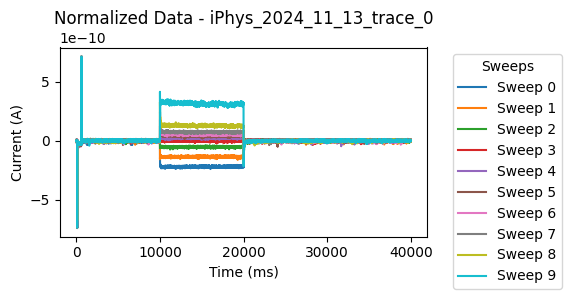

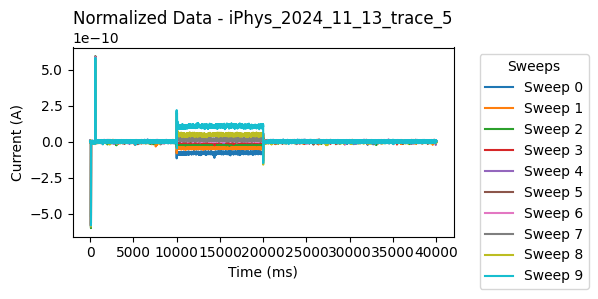

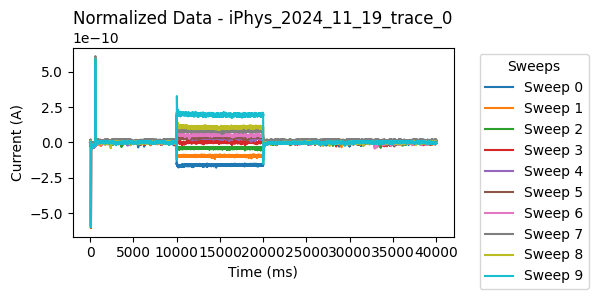

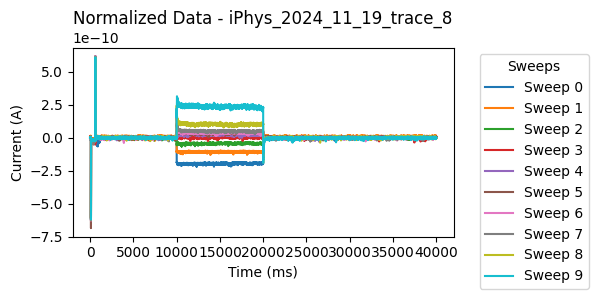

class:  ndarray
shape:  (4, 40001, 10)
strides:  (3200080, 80, 8)
itemsize:  8
aligned:  True
contiguous:  True
fortran:  False
data pointer: 0x7a534c3cc010
byteorder:  little
byteswap:  False
type: object
None


In [ ]:
# Example usage with both zero baseline normalization and capacitive current subtraction
directory = "/content/drive/MyDrive/Data/ePhys/"
# Guide rna experiments
grna_exps = ['iPhys_2024_11_13', 'iPhys_2024_11_13', 'iPhys_2024_11_19', 'iPhys_2024_11_19'] # hdf5 files
grna_traces = [0, 5, 0, 8] # trace numbers

grna_steps_sub_capacitive = PotassiumCurrentStepsImport(directory, grna_exps, grna_traces)
grna_experiments_sub_capacitive = grna_steps_sub_capacitive.import_traces()

# Print experiment names
print(grna_steps_sub_capacitive.experiments_list)

# Plot normalized traces
for name in grna_steps_sub_capacitive.experiments_list:
    grna_steps_sub_capacitive.plot_traces(name)

print(np.info(grna_experiments_sub_capacitive))


**Example Usage of Class PotassiumCurrentStepsImport Without Applying Capacitive Current Subtraction**

['iPhys_2024_11_13_trace_0', 'iPhys_2024_11_13_trace_5', 'iPhys_2024_11_19_trace_0', 'iPhys_2024_11_19_trace_8']


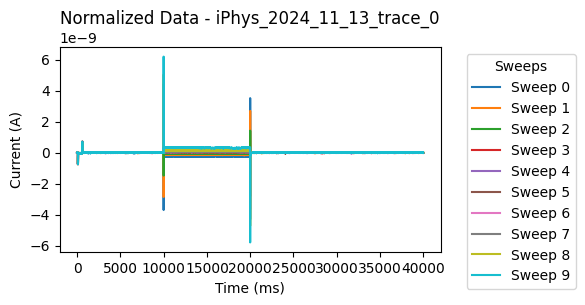

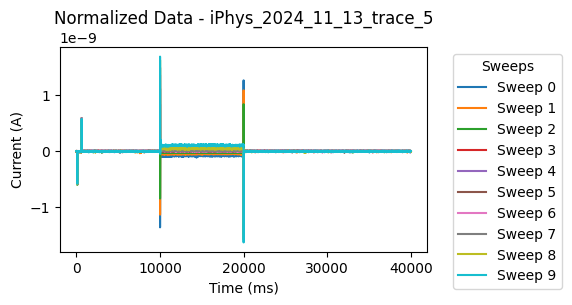

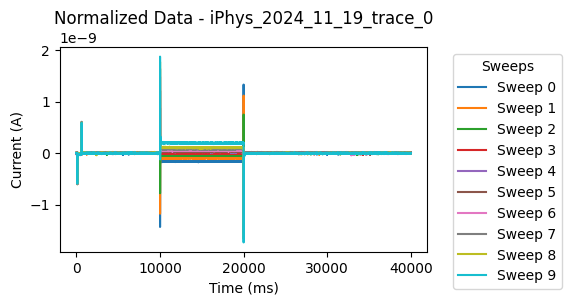

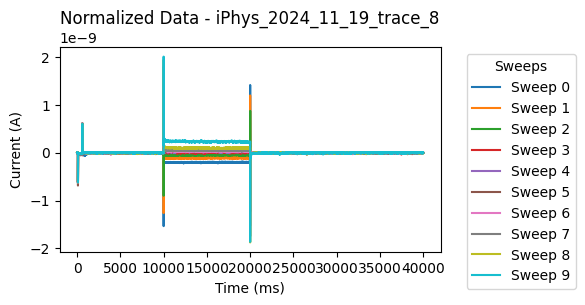

class:  ndarray
shape:  (4, 40001, 10)
strides:  (3200080, 80, 8)
itemsize:  8
aligned:  True
contiguous:  True
fortran:  False
data pointer: 0x7a534607f010
byteorder:  little
byteswap:  False
type: object
None


In [ ]:
# Example usage without capacitive current subtraction (set apply_capacitive_subtraction=False)
grna_steps = PotassiumCurrentStepsImport(directory, grna_exps, grna_traces, apply_capacitive_subtraction=False)
grna_experiments = grna_steps.import_traces() # array that is returned

# Print experiment names
print(grna_steps.experiments_list)

# Plot normalized traces
for name in grna_steps.experiments_list:
    grna_steps.plot_traces(name)

print(np.info(grna_experiments))

**Lists of Experiemtns and Traces**



In [ ]:

"""
aut1_exps = ('iPhys_2025_01_29 ', 'iPhys_2025_02_04', 'iPhys_2025_02_04')

aut1_control_traces = [4,11,25]

# traces after 20 minuets of drug application
aut1_traces = [12,19,33]


2um_aut5_exps = ('iPhys_2024_06_12_1 ', 'iPhys_2024_06_19', 'iPhys_2024_06_26', 'iPhys_2024_08_20', 'iPhys_2024_09_17')

2um_aut5_control_traces = [4,1,0,0,0]

# traces after 20 minuets of drug application
2um_aut5_traces = [18,11,7,8,8]

# Note: on 2024_11_06 the control traces for the first cell are contained in a different file from the traces with drug
20um_aut5_controls = ('iPhys_2024_10_01', 'iPhys_2024_11_06_1', 'iPhys_2024_11_06_2')

20um_aut5_exps = ('iPhys_2024_10_01', 'iPhys_2024_11_06_2', 'iPhys_2024_11_06_2')

20um_aut5_control_traces = [2,0,9]

# traces after 20 minuets of drug application
20um_aut5_traces = [11,4,17]
"""

guangxitoxin_exps = ('iPhys_2024_10_09', 'iPhys_2024_10_09', 'iPhys_2024_10_22_1',
                            'iPhys_2025_01_08', 'iPhys_2025_01_28', 'iPhys_2025_01_28')

guangxitoxin_control_traces = [0,13,1,0,3,20]

# traces after 20 minuets of drug application
guangxitoxin_traces = [8,22,9,9,11,30]


# Pooled control steps
pooled_control_exps = ('iPhys_2024_10_01', 'iPhys_2024_11_06_1', 'iPhys_2024_11_06_2', 'iPhys_2024_10_09',
             'iPhys_2024_06_12_1', 'iPhys_2024_06_19', 'iPhys_2024_06_26','iPhys_2024_10_09',
             'iPhys_2024_10_22_1', 'iPhys_2024_09_17', 'iPhys_2024_08_20')

pooled_control_traces = [2,0,9,0,4,1,0,13,1,0,0]


In [ ]:
# Import and normalize pooled control experiments without subtracting capacitive current
pooled_control_potassium_steps = PotassiumCurrentStepsImport(directory, pooled_control_exps,pooled_control_traces, apply_capacitive_subtraction=False)
pooled_control_experiments = pooled_control_potassium_steps.import_traces()

# Print experiment names
control_experiments_names = pooled_control_potassium_steps.experiments_list
print(control_experiments_names)
print(np.info(pooled_control_experiments))

['iPhys_2024_10_01_trace_2', 'iPhys_2024_11_06_1_trace_0', 'iPhys_2024_11_06_2_trace_9', 'iPhys_2024_10_09_trace_0', 'iPhys_2024_06_12_1_trace_4', 'iPhys_2024_06_19_trace_1', 'iPhys_2024_06_26_trace_0', 'iPhys_2024_10_09_trace_13', 'iPhys_2024_10_22_1_trace_1', 'iPhys_2024_09_17_trace_0', 'iPhys_2024_08_20_trace_0']
class:  ndarray
shape:  (11, 40001, 10)
strides:  (3200080, 80, 8)
itemsize:  8
aligned:  True
contiguous:  True
fortran:  False
data pointer: 0x7a5340942010
byteorder:  little
byteswap:  False
type: object
None


In [ ]:
# Import and normalize guangxitoxin controls without subtracting capacitive current
guangxitoxin_control_potassium_steps = PotassiumCurrentStepsImport(directory, guangxitoxin_exps, guangxitoxin_control_traces, apply_capacitive_subtraction=False)
guangxitoxin_controls = guangxitoxin_control_potassium_steps.import_traces()

# Print experiment names
guangxitoxin_controls_names = guangxitoxin_control_potassium_steps.experiments_list
print(guangxitoxin_controls_names)
print(np.info(guangxitoxin_controls))

['iPhys_2024_10_09_trace_0', 'iPhys_2024_10_09_trace_13', 'iPhys_2024_10_22_1_trace_1', 'iPhys_2025_01_08_trace_0', 'iPhys_2025_01_28_trace_3', 'iPhys_2025_01_28_trace_20']
class:  ndarray
shape:  (6, 40001, 10)
strides:  (3200080, 80, 8)
itemsize:  8
aligned:  True
contiguous:  True
fortran:  False
data pointer: 0x7a5336df2010
byteorder:  little
byteswap:  False
type: object
None


In [ ]:
# Import and normalize guangxitoxin experiments without subtracting capacitive current
guangxitoxin_potassium_steps = PotassiumCurrentStepsImport(directory, guangxitoxin_exps ,guangxitoxin_traces, apply_capacitive_subtraction=False)
guangxitoxin_experiments = guangxitoxin_potassium_steps.import_traces()

# Print experiment names
guangxitoxin_experiments_names = guangxitoxin_potassium_steps.experiments_list
print(guangxitoxin_experiments_names)
print(np.info(guangxitoxin_experiments))


['iPhys_2024_10_09_trace_8', 'iPhys_2024_10_09_trace_22', 'iPhys_2024_10_22_1_trace_9', 'iPhys_2025_01_08_trace_9', 'iPhys_2025_01_28_trace_11', 'iPhys_2025_01_28_trace_30']
class:  ndarray
shape:  (6, 40001, 10)
strides:  (3200080, 80, 8)
itemsize:  8
aligned:  True
contiguous:  True
fortran:  False
data pointer: 0x7a53311a2010
byteorder:  little
byteswap:  False
type: object
None


**Class SustainedPotassiumCurrentStepAnalysis Plots the Changes in Sustained Current vs Voltage Step**

In [ ]:
class SustainedPotassiumCurrentStepAnalysis:

    def __init__(self, control, manipulation, voltage_steps, time_window, experiment_name=None, current_type='Sustained', num_controls=None, num_experiments=None):
        """
        Initializes class for plotting voltage vs sustained current.

        Args:
            control (NumPy array): Control current traces of shape (num_traces, num_experiments).
            manipulation (NumPy array): Experimental manipulation current traces of shape (num_traces, num_experiments).
            voltage_steps (list): List of voltage steps.
            time_window (tuple): Time window for current analysis in milliseconds (start, end).
            experiment_name (str, optional): Name of the experimental condition. Defaults to None.
            current_type (str, optional): Type of current (sustained or transient). Defaults to None.
            num_controls (int, optional): Number of control traces. Defaults to None.
            num_experiments (int, optional): Number of experiment traces. Defaults to None.
        """
        self.control = control
        self.manipulation = manipulation
        self.voltage_steps = voltage_steps
        self.time_window = time_window
        self.experiment_name = experiment_name
        self.current_type = current_type
        self.num_controls = num_controls
        self.num_experiments = num_experiments

        # Compute statistics
        self.mean_currents_control = self.compute_mean_current(self.control)
        self.mean_currents_manipulation = self.compute_mean_current(self.manipulation)
        self.sem_currents_control = self.compute_sem(self.control)
        self.sem_currents_manipulation = self.compute_sem(self.manipulation)

    def compute_mean_current(self, data):
        """
        Computes the mean current for each voltage step over the specified time window.

        Args:
            data (NumPy array): Current traces of shape (num_traces, num_samples).

        Returns:
            NumPy array: Mean sustained current values for each voltage step.
        """
        mean_currents = []
        # Iterate over voltage steps - control
        for sweep_idx, voltage in enumerate(self.voltage_steps):
            # Extract current data for the specified time window
            mean_current = np.mean([trace[self.time_window[0]:self.time_window[1], sweep_idx].mean() for trace in data])
            mean_currents.append(mean_current)
        return np.array(mean_currents)


    def compute_sem(self, data):
        """
        Computes the standard error of the mean (SEM) for each voltage step.

        Args:
            data (NumPy array): Current traces of shape (num_traces, num_experiments).

        Returns:
            List: SEM values for each voltage step.
        """

        sem_values = []
        for sweep_idx, voltage in enumerate(self.voltage_steps):
            mean_current = np.array([trace[self.time_window[0]:self.time_window[1], sweep_idx].mean() for trace in data])
            sem = np.std(mean_current, ddof=1) / np.sqrt(len(data))
            sem_values.append(sem)
        return np.array(sem_values)

    def plot_voltage_sustained_current(self):
        """
        Plots voltage vs. mean sustained current for control and manipulation conditions with SEM.
        """
        # Create labels for the legend
        control_label = f'Control, n={self.num_controls}' if self.num_controls else 'Control'
        manipulation_label = f'{self.experiment_name}, n={self.num_experiments}' if self.experiment_name else 'Manipulation'
        current_type_label = f'Voltage-Steps vs {self.current_type} Current, {self.experiment_name}' if self.current_type else 'Current'

        # Plot voltage vs current
        plt.figure(figsize=(8, 6))
        plt.errorbar(self.voltage_steps, self.mean_currents_control, yerr=self.sem_currents_control, fmt='o-', color='b', ecolor='r', capsize=5, label=control_label)
        plt.errorbar(self.voltage_steps, self.mean_currents_manipulation, yerr=self.sem_currents_manipulation, fmt='o-', color='g', ecolor='r', capsize=5, label=manipulation_label)
        plt.title(current_type_label)
        plt.xlabel('Voltage Steps (mV)')
        plt.ylabel('Mean Current (pA)')
        plt.grid(True)
        plt.legend()
        plt.tight_layout()
        plt.show()
        plt.close()

        # Uncomment if NumPy arrays of the mean and sem values need to be returned
        #return self.mean_currents_control, self.mean_currents_manipulation, self.sem_currents_control, self.sem_currents_manipulation


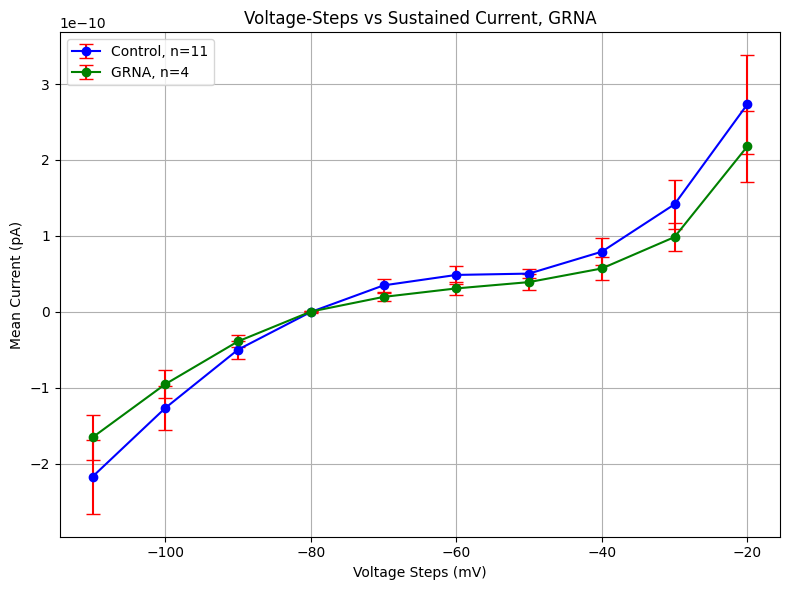

In [ ]:
control = pooled_control_experiments
manipulation = grna_experiments
time_window = (11000, 11100) # area of trace that is analyzed
voltage_steps = [-110, -100, -90, -80, -70, -60, -50, -40, -30, -20]
experiment_name = 'GRNA'
current_type = 'Sustained'
num_controls = len(control)
num_experiments = len(manipulation)

sus_current_grna = SustainedPotassiumCurrentStepAnalysis(control, manipulation, voltage_steps, time_window,
                                                 experiment_name, current_type, num_controls, num_experiments)

sus_current_grna.plot_voltage_sustained_current()


**The Class TransientPotassiumCurrentStepAnalysis Plots the Changes in the Transient Current vs Voltage Step**

**Note: the mean of the sustained current is subtracted from the mean of the transient current**

In [ ]:
class TransientPotassiumCurrentStepAnalysis:

    def __init__(self, control, manipulation, voltage_steps, current_time_window, baseline_time_window, experiment_name=None, current_type='Sustained', num_controls=None, num_experiments=None):
        """
        Initializes class for plotting voltage vs transient current.

        Args:
            control (NumPy array): Control current traces of shape (num_traces, num_experiments).
            manipulation (NumPy array): Experimental manipulation current traces of shape (num_traces, num_experiments).
            voltage_steps (list): List of voltage steps.
            current_time_window (tuple): time window for transient current analysis in milliseconds (start, end)
            baseline_time_window (tuple): time window for sustained current in milliseconds (start, end)
            experiment_name (str, optional): Name of the experimental condition. Defaults to None.
            current_type (str, optional): Type of current (sustained or transient). Defaults to None.
            num_controls (int, optional): Number of control traces. Defaults to None.
            num_experiments (int, optional): Number of experiment traces. Defaults to None.
        """
        self.control = np.array(control)
        self.manipulation = np.array(manipulation)
        self.voltage_steps = voltage_steps
        self.current_time_window = current_time_window
        self.baseline_time_window = baseline_time_window
        self.experiment_name = experiment_name
        self.current_type = current_type
        self.num_controls = num_controls
        self.num_experiments = num_experiments

        # Compute statistics
        self.mean_currents_control = self.compute_mean_transient_current(self.control)
        self.mean_currents_manipulation = self.compute_mean_transient_current(self.manipulation)
        self.sem_currents_control = self.compute_transient_sem(self.control)
        self.sem_currents_manipulation = self.compute_transient_sem(self.manipulation)

    def compute_mean_transient_current(self, data):
        """
        Computes the mean current for each voltage step over the specified time window.

        Args:
            data (NumPy array): Current traces of shape (num_traces, num_samples).

        Returns:
            NumPy array: Mean sustained current values for each voltage step.
        """

        mean_currents = []
        # Iterate over voltage steps - control
        for sweep_idx, voltage in enumerate(self.voltage_steps):
            # Extract baseline current data for the specified time window
            mean_baseline = np.mean([trace[self.baseline_time_window[0]:self.baseline_time_window[1], sweep_idx].mean() for trace in data])
            # Extract current data for the specified time window
            mean_current = np.mean([trace[self.current_time_window[0]:self.current_time_window[1], sweep_idx].mean() for trace in data])
            mean_current -= mean_baseline
            mean_currents.append(mean_current)
        return np.array(mean_currents)


    def compute_transient_sem(self, data):
        """
        Computes the standard error of the mean (SEM) for each voltage step.

        Args:
            data (NumPy array): Current traces of shape (num_traces, num_experiments).

        Returns:
            List: SEM values for each voltage step.
        """

        sem_values = []
        for sweep_idx, voltage in enumerate(self.voltage_steps):
            baseline_values = np.array([trace[self.baseline_time_window[0]:self.baseline_time_window[1], sweep_idx].mean() for trace in data])
            current_values = np.array([trace[self.current_time_window[0]:self.current_time_window[1], sweep_idx].mean() for trace in data])

            # Subtract baseline from current values
            normalized_currents = current_values - baseline_values

            # Compute SEM with corrected values
            sem = np.std(normalized_currents, ddof=1) / np.sqrt(len(normalized_currents))
            sem_values.append(sem)
        return np.array(sem_values)

    def plot_voltage_transient_current(self):
        """
        Plots voltage vs. mean sustained current for control and manipulation conditions with SEM.
        """
        # Create labels for the legend
        control_label = f'Control, n={self.num_controls}' if self.num_controls else 'Control'
        manipulation_label = f'{self.experiment_name}, n={self.num_experiments}' if self.experiment_name else 'Manipulation'
        current_type_label = f'Voltage-Steps vs {self.current_type} Current, {self.experiment_name}' if self.current_type else 'Current'

        # Plot voltage vs current
        plt.figure(figsize=(8, 6))
        plt.errorbar(self.voltage_steps, self.mean_currents_control, yerr=self.sem_currents_control, fmt='o-', color='b', ecolor='r', capsize=5, label=control_label)
        plt.errorbar(self.voltage_steps, self.mean_currents_manipulation, yerr=self.sem_currents_manipulation, fmt='o-', color='g', ecolor='r', capsize=5, label=manipulation_label)
        plt.title(current_type_label)
        plt.xlabel('Voltage Steps (mV)')
        plt.ylabel('Mean Current (pA)')
        plt.grid(True)
        plt.legend()
        plt.tight_layout()
        plt.show()
        plt.close()

        # Uncomment if NumPy arrays of the mean and sem values need to be returned
        #return self.mean_currents_control, self.mean_currents_manipulation, self.sem_currents_control, self.sem_currents_manipulation


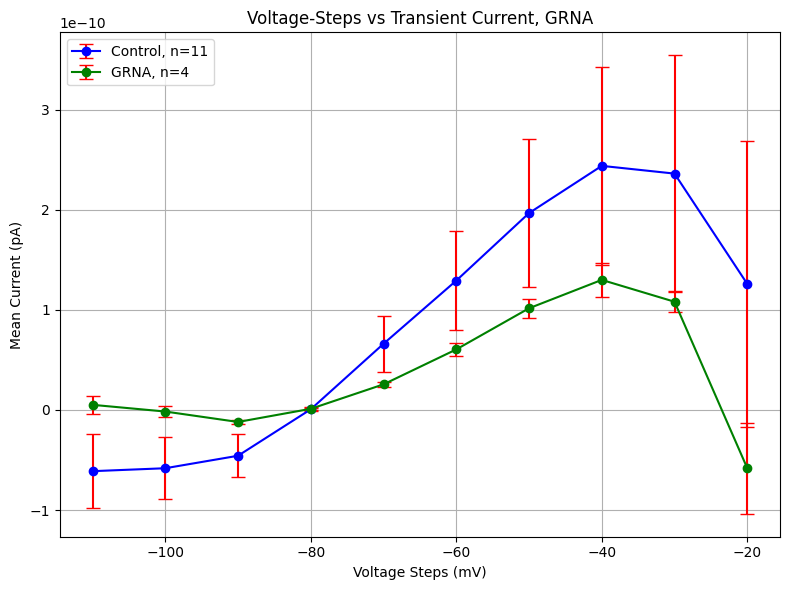

In [ ]:
control = pooled_control_experiments
manipulation = grna_experiments
voltage_steps = [-110, -100, -90, -80, -70, -60, -50, -40, -30, -20]
current_time_window = (10007, 10009) # area of trace that is analyzed
baseline_time_window = (12000, 12100) # area of trace to subtract out
experiment_name = 'GRNA'
current_type = 'Transient'
num_controls = len(control)
num_experiments = len(manipulation)

trans_current_grna = TransientPotassiumCurrentStepAnalysis(control, manipulation, voltage_steps, current_time_window,
                                                 baseline_time_window, experiment_name, current_type, num_controls, num_experiments)

trans_current_grna.plot_voltage_transient_current()

**The Class CurrentDecayStepAnalysis Plots the Changes in the Transient Current Decay Time vs Voltage Step**

**Current Decay Time is Fit to a Single Exponential Function**


In [ ]:
class CurrentDecayStepAnalysis:
    def __init__(self, control, manipulation, voltage_steps, time_window, tau, experiment_name=None, num_controls=None, num_exeriments=None):
        """
        Initializes class for plotting voltage vs current decay time.

        Args:
            control (NumPy array): Control current traces of shape (num_traces, num_experiments).
            manipulation (NumPy array): Experimental manipulation current traces of shape (num_traces, num_experiments).
            voltage_steps (list): List of voltage steps.
            time_window (tuple): Tuple (start_idx, end_idx) indicating the time window for decay fitting.
            tau (integer): an estimate of the exponential decay time constant.
            experiment_name (str, optional): Name of the experimental condition. Defaults to None.
            num_controls (int, optional): Number of control traces. Defaults to None.
            num_experiments (int, optional): Number of experiment traces. Defaults to None.
        """
        self.control = np.array(control).T
        self.manipulation = np.array(manipulation).T
        self.voltage_steps = voltage_steps
        self.time_window = time_window
        self.tau = tau
        self.experiment_name = experiment_name
        self.num_controls = num_controls
        self.num_experiments = num_experiments

        # Compute statistics
        self.mean_decay_time_control = self.compute_mean_decay_time(self.control)
        self.mean_decay_time_manipulation = self.compute_mean_decay_time(self.manipulation)
        self.sem_decay_time_control = self.compute_sem_decay_time(self.control)
        self.sem_decay_time_manipulation = self.compute_sem_decay_time(self.manipulation)

    def exponential_decay(self, x, a, tau, c):
        """Exponential decay function"""
        return a * np.exp(-x / tau) + c

    def compute_mean_decay_time(self, data):
        """
        Compute the mean decay time for the data.

        Args:
            data (numpy array): Array of current traces (num_traces x num_experiments).

        Returns:
            numpy array: Mean decay times for each voltage step.
        """
        decay_times = []
        start_idx, end_idx = self.time_window
        time_points = np.arange(end_idx - start_idx)

        for experiment_idx, sweeps in enumerate(data):  # Iterate through voltage steps
            sweep_decay_times = []  # Store decay times for this voltage step

            for i, sweep in enumerate(sweeps.T):  # Iterate through different experiments
                sweep_window = sweep[start_idx:end_idx]
                a = np.max(sweep_window) - np.min(sweep_window)
                tau_estimate = self.tau
                c = np.min(sweep_window)

                try:
                    popt, _ = curve_fit(self.exponential_decay, time_points, sweep_window, p0=[a, tau_estimate, c])
                    _, tau_fit, _ = popt
                    if tau_fit > tau_estimate * 3 or tau_fit < 0:
                        tau_fit = 0
                    sweep_decay_times.append(tau_fit)

                except RuntimeError:
                    # If curve fitting fails, append NaN
                    sweep_decay_times.append(np.nan)

            # Compute mean for this voltage step and append to decay_times
            decay_times.append(np.nanmean(sweep_decay_times, axis=0))

        return np.array(decay_times)

    def compute_sem_decay_time(self, data):
        """
        Compute the standard error of the mean (SEM) for decay times.

        Args:
            data (numpy array): Array of current traces (num_traces x num_experiments).

        Returns:
            numpy array: SEM decay times for each voltage step.
        """
        sem_decay_times = []
        start_idx, end_idx = self.time_window
        time_points = np.arange(end_idx - start_idx)

        for experiment_idx, sweeps in enumerate(data):  # Iterate through voltage steps
            sweep_decay_times = []  # Store decay times for this voltage step

            for i, sweep in enumerate(sweeps.T):
                sweep_window = sweep[start_idx:end_idx]
                a = np.max(sweep_window) - np.min(sweep_window)
                tau_estimate = self.tau
                c = np.min(sweep_window)

                try:
                    popt, _ = curve_fit(self.exponential_decay, time_points, sweep_window, p0=[a, tau_estimate, c])
                    _, tau_fit, _ = popt
                    if tau_fit > tau_estimate * 3 or tau_fit < 0:
                        tau_fit = 0
                    sweep_decay_times.append(tau_fit)

                except RuntimeError:
                    # If curve fitting fails, append NaN
                    sweep_decay_times.append(np.nan)

            # Compute SEM for this voltage step and append to sem_decay_times
            sem_decay_times.append(np.nanstd(sweep_decay_times, axis=0) / np.sqrt(np.count_nonzero(~np.isnan(sweep_decay_times), axis=0)))


        return np.array(sem_decay_times)

    def plot_voltage_current_decay_time(self):
        """Plots voltage vs. mean decay time for control and manipulation conditions with SEM."""
        control_label = f'Control, n={self.num_controls}' if self.num_controls else 'Control'
        manipulation_label = f'{self.experiment_name}, n={self.num_experiments}' if self.experiment_name else 'Manipulation'
        title = f'Voltage-Steps vs Current Decay Time, {self.experiment_name}'

        plt.figure(figsize=(8, 6))
        plt.errorbar(self.voltage_steps, self.mean_decay_time_control, yerr=self.sem_decay_time_control, fmt='o-', color='b', capsize=5, label=control_label)
        plt.errorbar(self.voltage_steps, self.mean_decay_time_manipulation, yerr=self.sem_decay_time_manipulation, fmt='o-', color='g', capsize=5, label=manipulation_label)
        plt.title(title)
        plt.xlabel('Voltage Steps (mV)')
        plt.ylabel('Decay Time (ms)')
        plt.grid(True)
        plt.legend()
        plt.tight_layout()
        plt.show()

        # Uncomment if NumPy arrays of the mean and sem values need to be returned
        #return self.mean_decay_time_control, self.mean_decay_time_manipulation, self.sem_decay_time_control, self.sem_decay_time_manipulation


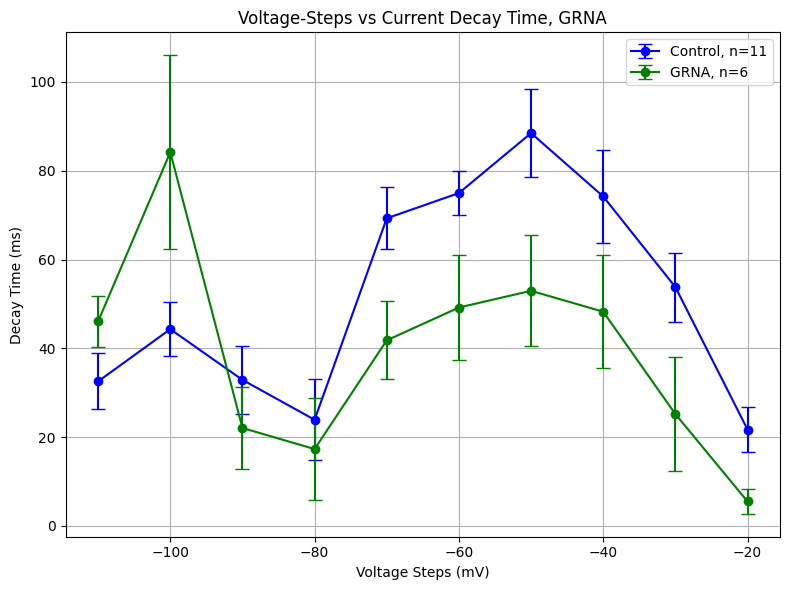

In [ ]:
control = pooled_control_experiments
manipulation = grna_experiments
voltage_steps = [-110, -100, -90, -80, -70, -60, -50, -40, -30, -20]
time_window = (10010, 10350)
tau = 60
experiment_name = 'GRNA'
num_controls = len(control)
num_experimetns = len(manipulation)

current_decay_grna = CurrentDecayStepAnalysis(control, manipulation, voltage_steps, time_window, tau, experiment_name, num_controls, num_experiments)
current_decay_grna.plot_voltage_current_decay_time()

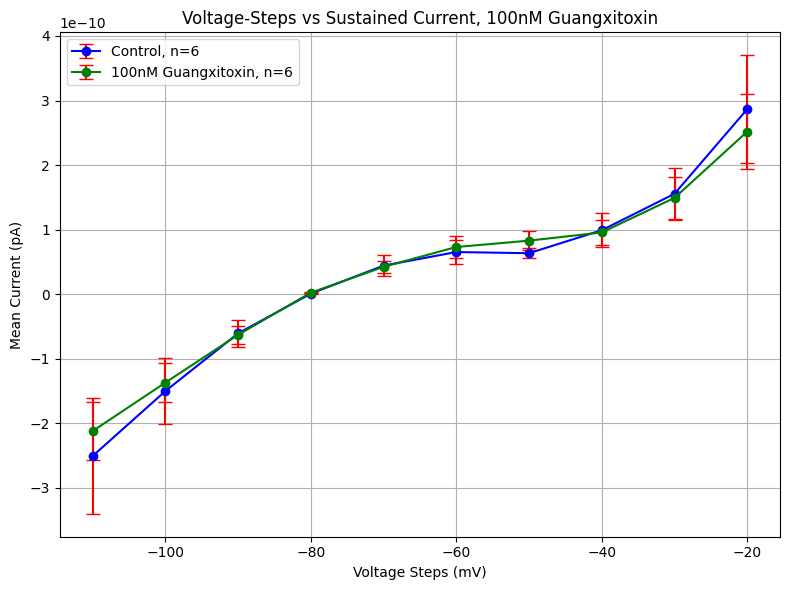

In [ ]:
control = guangxitoxin_controls
manipulation = guangxitoxin_experiments
time_window = (11000, 11100) # area of trace that is analyzed
voltage_steps = [-110, -100, -90, -80, -70, -60, -50, -40, -30, -20]
experiment_name = '100nM Guangxitoxin'
current_type = 'Sustained'
num_controls = len(control)
num_experiments = len(manipulation)

sus_current_gxtx = SustainedPotassiumCurrentStepAnalysis(control, manipulation, voltage_steps, time_window,
                                                 experiment_name, current_type, num_controls, num_experiments)

sus_current_gxtx.plot_voltage_sustained_current()

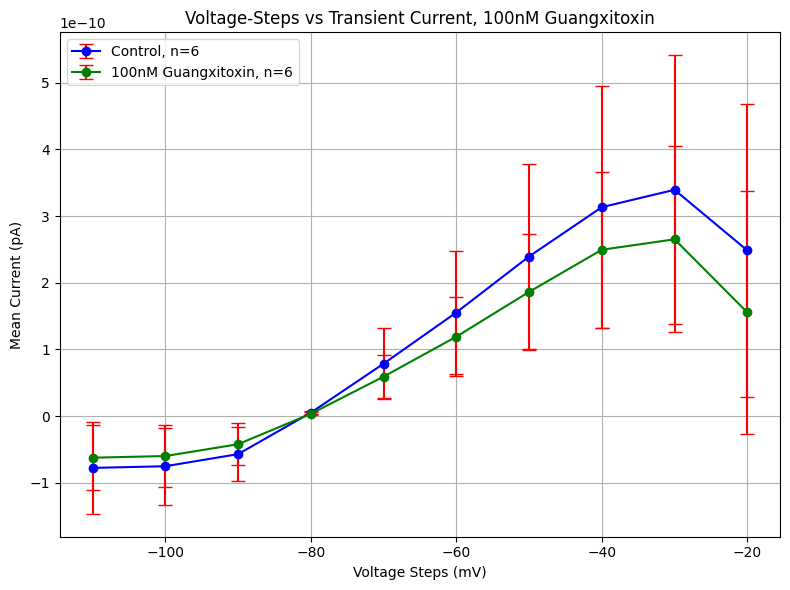

In [ ]:
control = guangxitoxin_controls
manipulation = guangxitoxin_experiments
voltage_steps = [-110, -100, -90, -80, -70, -60, -50, -40, -30, -20]
current_time_window = (10007, 10009) # area of trace that is analyzed
baseline_time_window = (12000, 12100) # area of trace to subtract out
experiment_name = '100nM Guangxitoxin'
current_type = 'Transient'
num_controls = len(control)
num_experiments = len(manipulation)

trans_current_gxtx = TransientPotassiumCurrentStepAnalysis(control, manipulation, voltage_steps, current_time_window,
                                                 baseline_time_window, experiment_name, current_type, num_controls, num_experiments)

trans_current_gxtx.plot_voltage_transient_current()

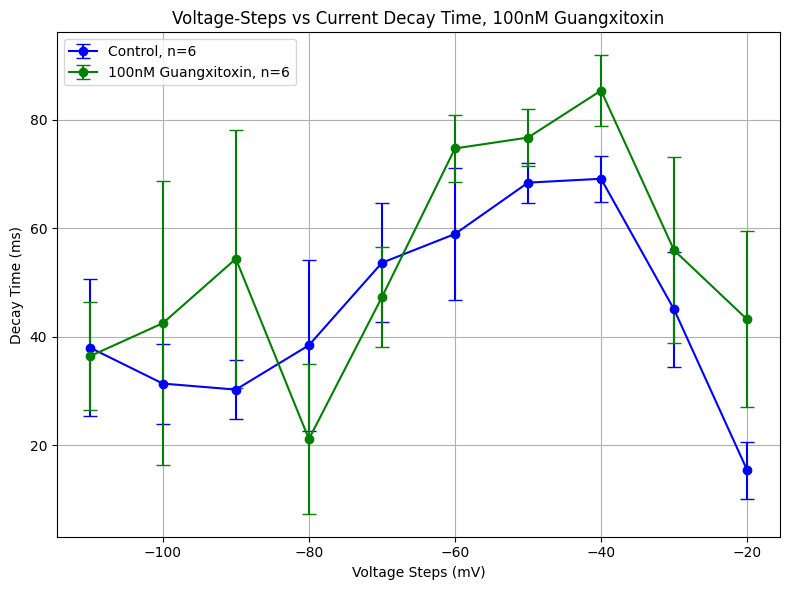

In [ ]:
control = guangxitoxin_controls
manipulation = guangxitoxin_experiments
voltage_steps = [-110, -100, -90, -80, -70, -60, -50, -40, -30, -20]
time_window = (10010, 10350)
tau = 60
experiment_name = '100nM Guangxitoxin'
num_controls = len(control)
num_experimetns = len(manipulation)

current_decay_gxtx = CurrentDecayStepAnalysis(control, manipulation, voltage_steps, time_window, tau, experiment_name, num_controls, num_experiments)
current_decay_gxtx.plot_voltage_current_decay_time()